In [1]:
import jax
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import sys; sys.path.insert(1, '..')

from algs.train import IRL_Trainer, TracePlotter
from env.utils import ExampleMDPs
from env.sample import Sampler
from algs.irl import irlL1Proj
from algs.irl import initStateOnlyIRL, stochNaturalIRL

import jax.numpy as jnp

### Example training with oracle access to the gradients

In [2]:
mdp = ExampleMDPs.gworld1()
trainer = IRL_Trainer(mdp,policy_lr=2,reward_lr=2e-1,beta=0.1)
optimizers, trace = trainer.train(300)

Computing the expert's policy


100%|██████████| 300/300 [00:07<00:00, 42.44it/s]


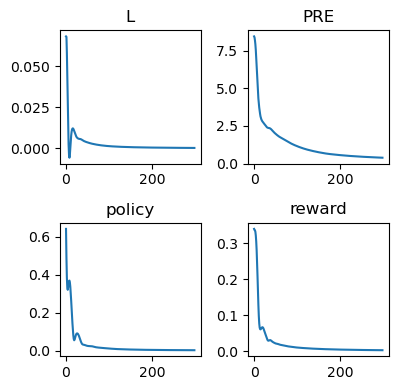

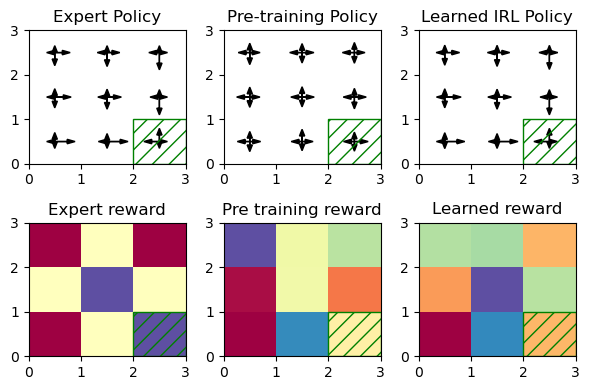

In [3]:
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,trainer,optimizers,trace,(4,4))
_ = TracePlotter.gworldIRLPlot(trainer,optimizers,trace,fsize=(6,4))

### Example training with state-only-rewards

In [4]:
state_only = lambda w : jnp.repeat(w,mdp.m,1)
mdp = ExampleMDPs.gworld1()
w_ref = jnp.expand_dims(jnp.array([1 if s==2 else 0 for  s in range(9)]),1)
mdp.R = state_only(w_ref)
trainer = IRL_Trainer(mdp,policy_lr=2,reward_lr=2e-1,beta=0.1,rFun=state_only,init_params=initStateOnlyIRL)
optimizers, trace = trainer.train(60)

Computing the expert's policy


100%|██████████| 60/60 [00:02<00:00, 21.75it/s]


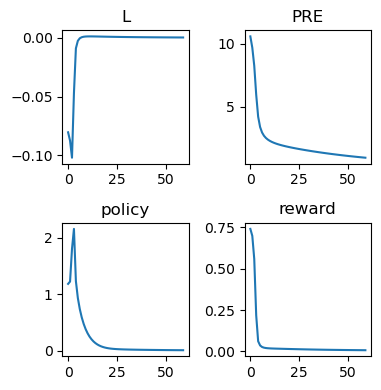

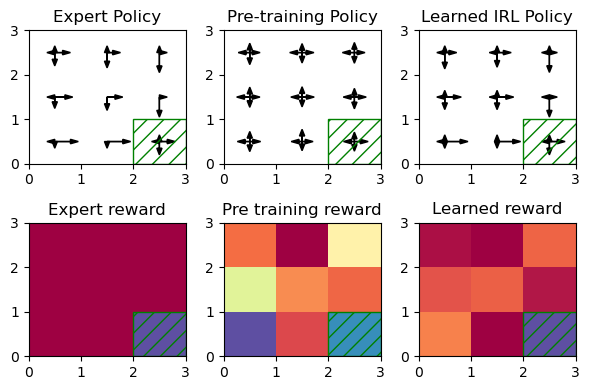

In [5]:
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,trainer,optimizers,trace,(4,4))
_ = TracePlotter.gworldIRLPlot(trainer,optimizers,trace,fsize=(6,4))

### Example training with stochastic gradient estimators

In [6]:
state_only = lambda w : jnp.repeat(w,mdp.m,1)
mdp = ExampleMDPs.gworld1()
w_ref = jnp.expand_dims(jnp.array([1 if s==2 else 0 for  s in range(9)]),1)
mdp.R = state_only(w_ref)
smp = Sampler(mdp,batchsize=1000,horizon=250)
trainer = IRL_Trainer(mdp,policy_lr=1e-1,reward_lr=5e-2,beta=0.1,
                      init_params=initStateOnlyIRL,
                      sampler=smp,
                      rFun=state_only,
                      gradients=stochNaturalIRL,
                      max_theta=80,
                      proj=irlL1Proj,
                      key = jax.random.PRNGKey(1312))
optimizers, trace = trainer.train(100)

Computing the expert's policy


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


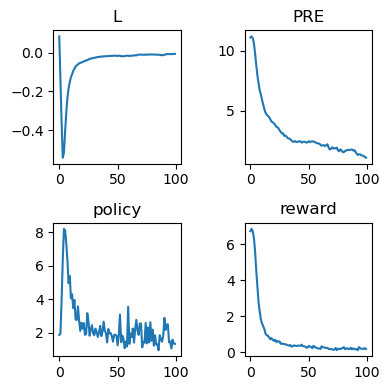

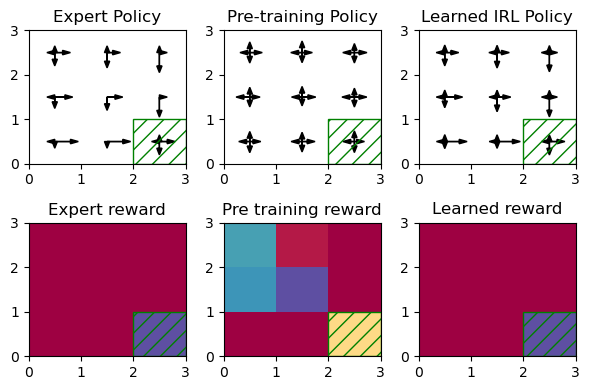

In [7]:
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,trainer,optimizers,trace,(4,4))
plt.show(); #plt.plot(jnp.array([jnp.max(e['params']['policy']) for e in trace]))
_ = TracePlotter.gworldIRLPlot(trainer,optimizers,trace,fsize=(6,4))